# Heart Failure Prediction
`Omar El Yousfi`
# Introduction:
To predict a heart failure case, we will use multiple machine learning models, in order to find the best performing algorithm. In order to achieve that, we have to choose an evaluation metric. Since we want to minimize False Negatives, meaning we do not want to predict that someone does not have heart failure and they turn out they do. Therefore, we will use Recall as our evaluation metric. <br> 
Before moving to model building and hyperparameter tunning, we will first clean the data and perform necessary pre processing steps and EDA.

## Importing Necessary Packages and Dataset 

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../input/heart-failure-prediction/heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Exploratory Data Analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Looking at the summary of the data, we can see that initially we have no missing values, which we will investigate later on. We also see that some columns should be converted to "category" type such as *Sex*, and *ChestPainType*.

### Statistic Summary

In [4]:
data.describe().T.style.background_gradient(cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
Age,918.000000,53.510893,9.432617,28.000000,47.000000,54.000000,60.000000,77.000000
RestingBP,918.000000,132.396514,18.514154,0.000000,120.000000,130.000000,140.000000,200.000000
Cholesterol,918.000000,198.799564,109.384145,0.000000,173.250000,223.000000,267.000000,603.000000
FastingBS,918.000000,0.233115,0.423046,0.000000,0.000000,0.000000,0.000000,1.000000
MaxHR,918.000000,136.809368,25.460334,60.000000,120.000000,138.000000,156.000000,202.000000
Oldpeak,918.000000,0.887364,1.066570,-2.600000,0.000000,0.600000,1.500000,6.200000
HeartDisease,918.000000,0.553377,0.497414,0.000000,0.000000,1.000000,1.000000,1.000000


While analyzing this statistical summary, we notice that minimum value of Cholesterol is 0, which is odd since the serum Cholesterol minimum value is 50-60, which may indicate that there are missing values that we noted as 0 in the dataset, we will investigate these in the pre processing part. <br>
We can see that the mean age and median age of our observations coincide, which indicates that this column is normally distributed, also that patiens in our dataset are old => older people get more heart failure problems than younger people. <br>

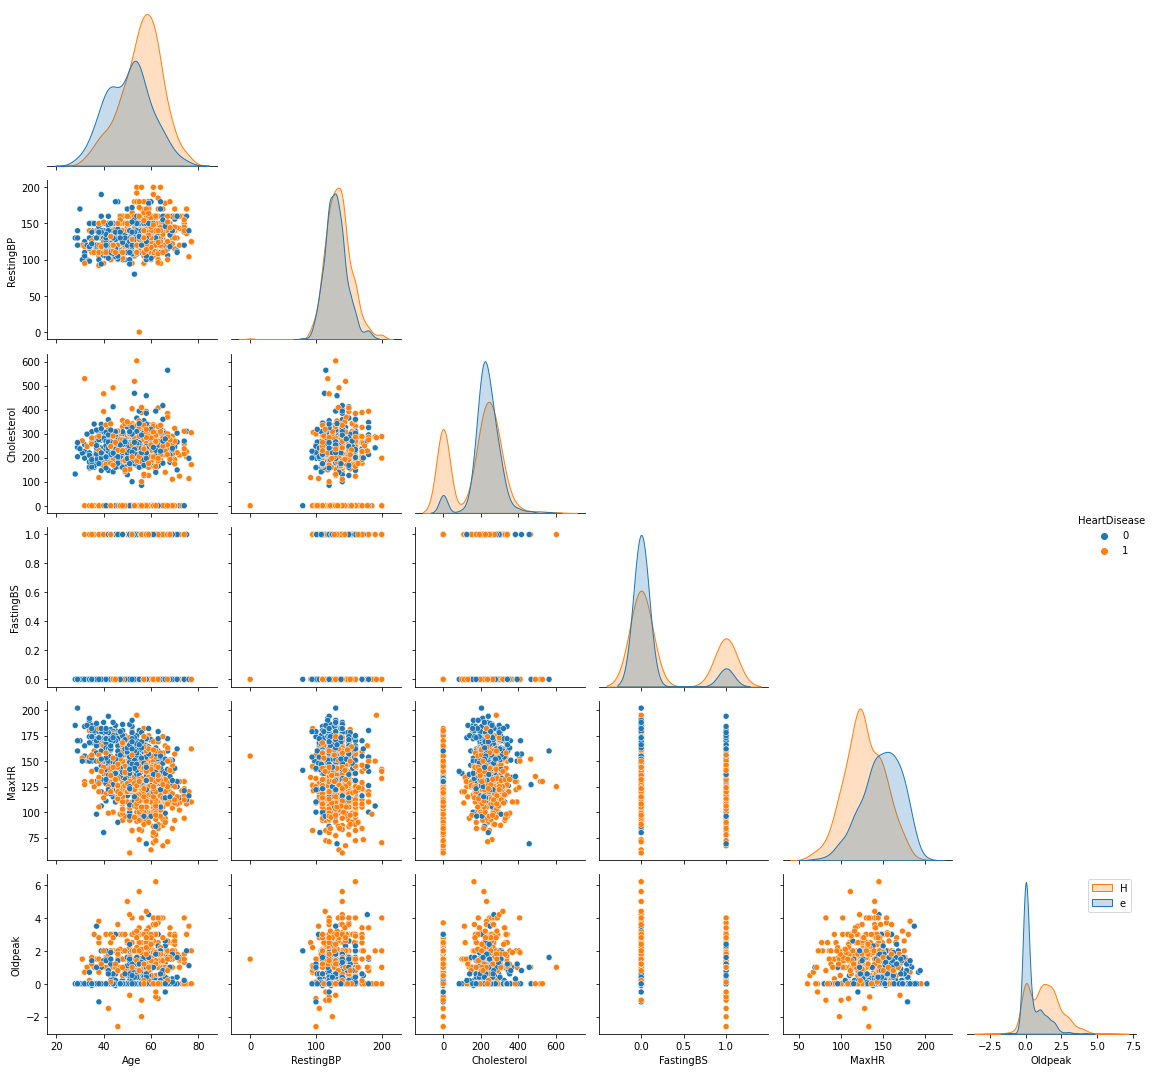

In [5]:
sns.pairplot(data, hue="HeartDisease", corner=True)
plt.legend("HeartDisease")
plt.tight_layout()
plt.show()

Looking at this pairplot, we can find some patters in the data but they are not quite apparent.

### Distributions

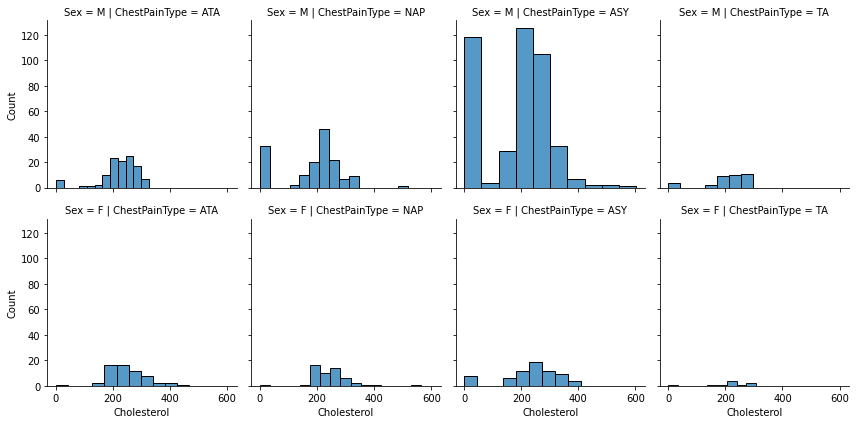

In [6]:
g = sns.FacetGrid(data, row="Sex", col="ChestPainType")
g.map_dataframe(sns.histplot, "Cholesterol")
plt.show()

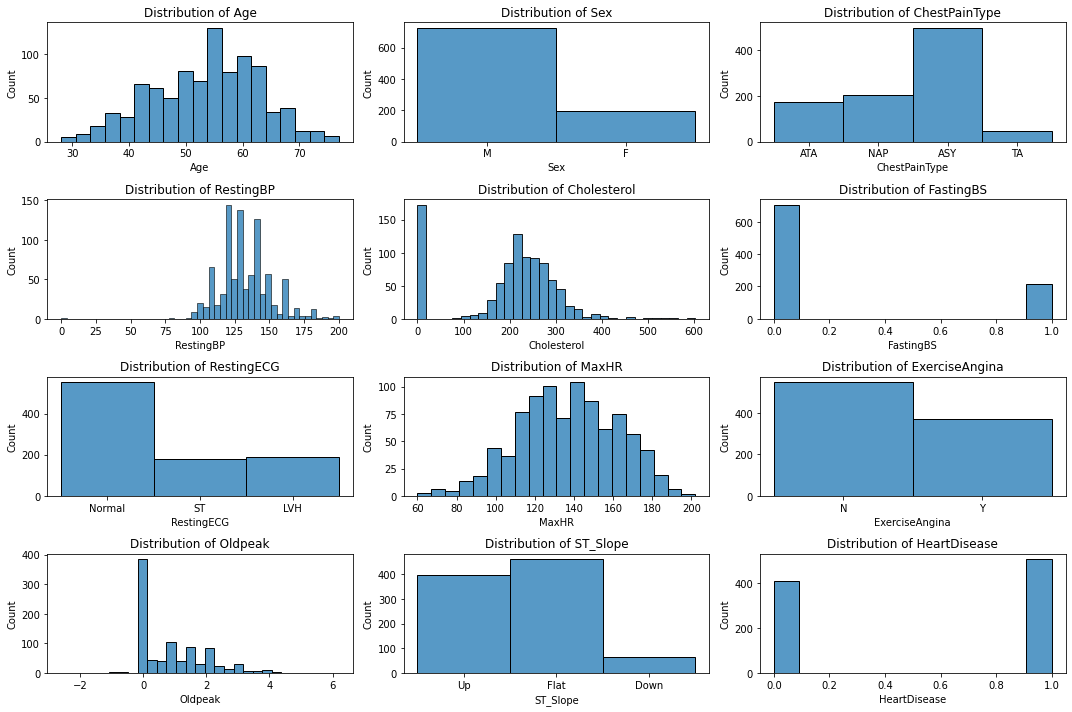

In [7]:
plt.figure(figsize=(15,10))
for i, col in enumerate(data.columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(x=col, data=data)
    plt.title("Distribution of {}".format(col))
    plt.tight_layout()
plt.show()

### Boxplots

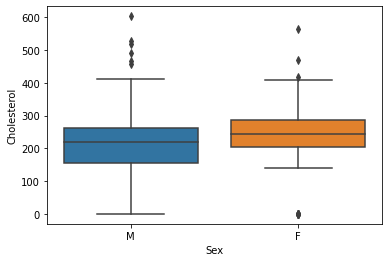

In [8]:
sns.boxplot(x="Sex", y="Cholesterol", data=data)
plt.show()

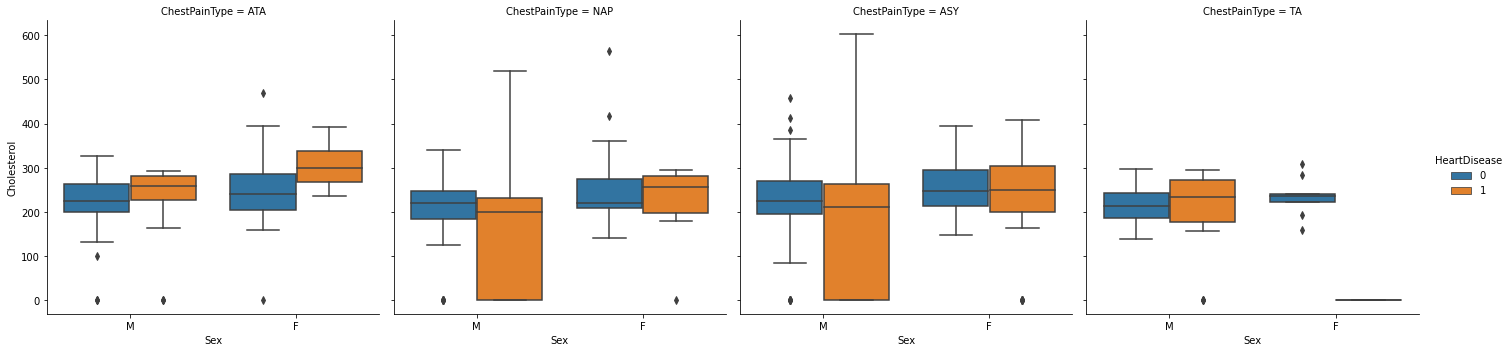

In [9]:
sns.catplot(x="Sex", y="Cholesterol", hue="HeartDisease", col="ChestPainType", data=data, kind="box")
plt.show()

## Pre-Processing

First step in the pre processing, we have to change the type of categories to "category".

In [10]:
categories = ["ChestPainType","RestingECG", "ChestPainType", "ST_Slope", "ExerciseAngina", "Sex"]
for cat in categories:
    data[cat] = data[cat].astype("category")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int64   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int64   
 4   Cholesterol     918 non-null    int64   
 5   FastingBS       918 non-null    int64   
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int64   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    int64   
dtypes: category(5), float64(1), int64(6)
memory usage: 55.5 KB


Is recall a good metric for our data? We should check if the data is balanced, if not, we will have to use F1-score.

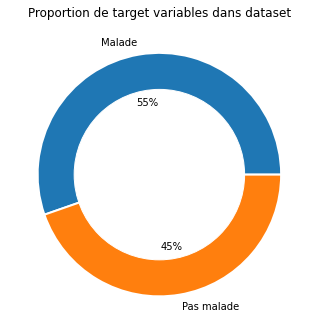

In [11]:
plt.figure(figsize=(12,6))
plt.subplot(122)
plt.pie(data["HeartDisease"].value_counts().values,
        labels=["Malade","Pas malade"],
        autopct="%1.0f%%",wedgeprops={"linewidth":2,"edgecolor":"white"})
my_circ = plt.Circle((0,0),.7,color = "white")
plt.gca().add_artist(my_circ)
plt.subplots_adjust(wspace = .2)
plt.title("Proportion de target variables dans dataset")
plt.show()

In [12]:
data['HeartDisease'].value_counts(normalize = True)

1    0.553377
0    0.446623
Name: HeartDisease, dtype: float64

Our data is balanced since 55% of observations are sick, and 45% are not.

In the following heatmap, we will check if we have multi correlations in our data. As it looks, there is correlation.

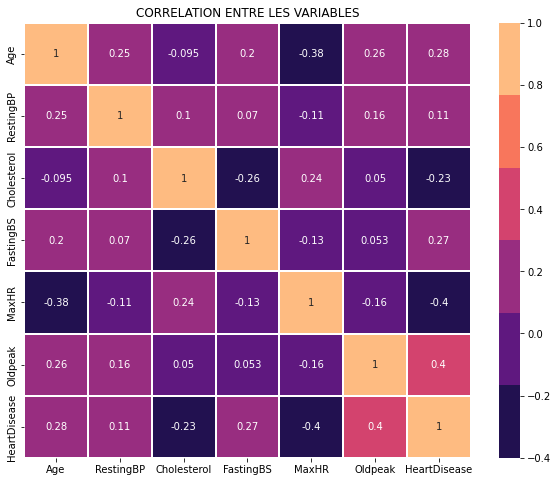

In [13]:
correlation = data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation,annot=True,
            cmap=sns.color_palette("magma"),
            linewidth=2,edgecolor="k")
plt.title("CORRELATION ENTRE LES VARIABLES")
plt.show()

In the scope of descriptive analysis, we will check the type of distribution of some of our columns, we will use the following function to calculate the Empirical Cumulative Distribution Function of Cholesterol.

In [14]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

As I mentioned before, the minimum value of cholesterol can not be 0, we can imputate this using Imputer of sklearn or easily we can convert these '0' to 'NaN' and fill these values with the mean Cholesterol.

In [15]:
data["Cholesterol"].describe()

count    918.000000
mean     198.799564
std      109.384145
min        0.000000
25%      173.250000
50%      223.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64

The distance between 0 values and the rest of the data is more apparent in the following ecdf.

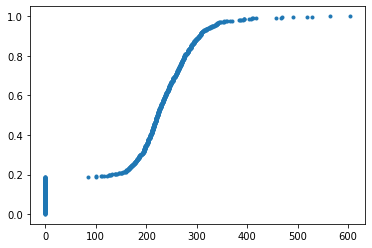

In [16]:
x, y = ecdf(data["Cholesterol"])

plt.plot(x, y, marker=".", linestyle = 'none')
plt.show()

Also in this histogram:

<AxesSubplot:>

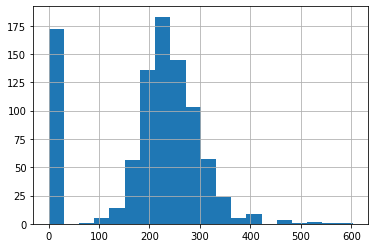

In [17]:
data["Cholesterol"].hist(bins=20)

We can see we have some outliers, that have value of 0 which is impossible, which indicates that these observations maybe have missing cholesterol values.

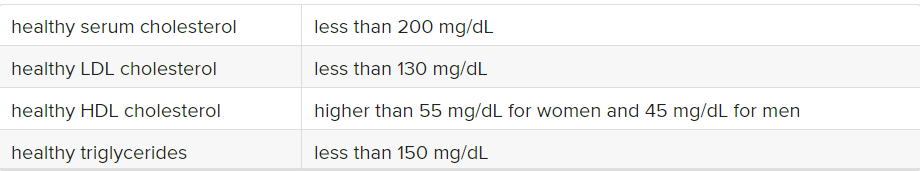

The range of serum cholestrol in the previous chart, agrees with our theory that observations with 0 serum cholesterol level are missing. <br>
Source: https://www.healthline.com/health/serum-cholesterol#results

In [18]:
data["Cholesterol"].replace(0, np.nan, inplace=True)
data["Cholesterol"].fillna(data["Cholesterol"].mean(), inplace=True)

What about the distribution of the data? To check for it, we will plot the Cholesterol column with a theoritical Normal Distribution ecdf.

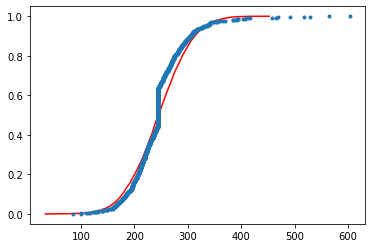

In [19]:
x, y = ecdf(data["Cholesterol"])
samples = np.random.normal(data["Cholesterol"].mean(), data["Cholesterol"].std(), 10000)
x_theor, y_theor = ecdf(samples)
plt.plot(x_theor, y_theor, color="red")
plt.plot(x, y, marker=".", linestyle = 'none')
plt.show()

As we can see, Cholesterol is normally distributed.

The same problem occurs in the RestingBP column, I will perform the same steps I did in the Cholesterol column.

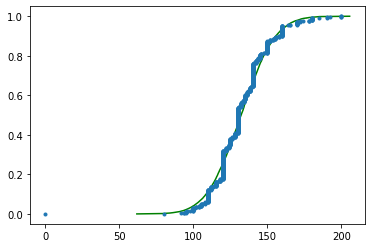

In [20]:
x, y = ecdf(data["RestingBP"])
samples1 = np.random.normal(data["RestingBP"].mean(), data["RestingBP"].std(), 10000)
x_theor1, y_theor1 = ecdf(samples1)
plt.plot(x_theor1, y_theor1, color="green")
plt.plot(x, y, marker=".", linestyle = 'none')
plt.show()

<AxesSubplot:>

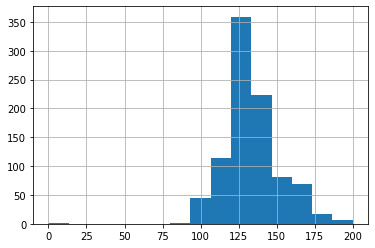

In [21]:
data["RestingBP"].hist(bins=15)

Same thing for `RestingBP` column.

In [22]:
data["RestingBP"].replace(0, np.nan, inplace=True)
data["RestingBP"].fillna(data["RestingBP"].mean(), inplace=True)

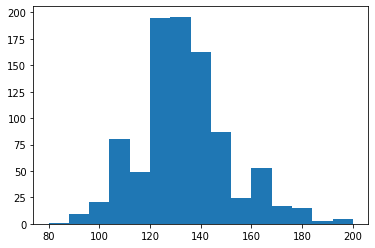

In [23]:
plt.hist(data['RestingBP'], bins = 15)
plt.show()

Finally, I will use get_dummies function of pandas to convert categorical values to numerical, in order to train a machine learning model.

In [24]:
data = pd.get_dummies(data, drop_first=True, columns=categories)
data.sample(10)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ST_Slope_Flat,ST_Slope_Up,ExerciseAngina_Y,Sex_M
745,63,108.0,269.000000,0,169,1.8,1,0,0,0,1,0,0,0,0,1,0,1,0
673,59,174.0,249.000000,0,143,0.0,1,0,0,0,1,0,0,0,0,1,0,1,0
835,54,110.0,239.000000,0,126,2.8,1,0,0,0,1,0,0,0,0,1,0,1,1
684,47,108.0,243.000000,0,152,0.0,1,0,1,0,1,0,0,1,0,0,1,0,1
317,56,140.0,244.635389,1,121,1.8,1,0,0,0,1,0,0,0,0,0,1,1,1
504,62,158.0,210.000000,1,112,3.0,1,0,0,0,1,0,0,0,0,0,0,1,1
655,40,152.0,223.000000,0,181,0.0,1,0,0,0,1,0,0,0,0,0,1,0,1
318,61,130.0,244.635389,1,77,2.5,1,0,0,0,1,0,0,0,0,1,0,0,1
555,58,150.0,219.000000,0,118,0.0,1,0,1,0,0,1,0,1,0,1,0,1,1
161,49,128.0,212.000000,0,96,0.0,1,0,0,0,1,0,0,0,0,1,0,1,1


Drop the target values from the dataset.

In [25]:
target= data['HeartDisease']
data.drop(columns=['HeartDisease'], inplace=True)

### Principal Component Analysis (PCA)

Before performing PCA, we will have to check for number of components we will have to keep, I will be keeping the components with significant variance in the data. 

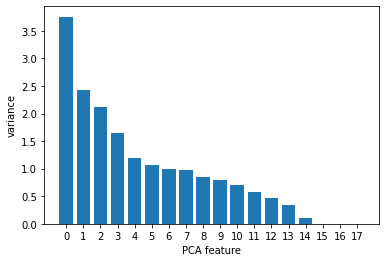

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()

pca = PCA()

pipeline = make_pipeline(scaler, pca)

pipeline.fit(data)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()


In this case we can go with eaither 4 components or 5, both vary significantly.

### Data Scaling

As a last step of the pre processing, I will be using StandardScaler of sklearn to standarize data, since some algorithms such as KNN use distance to predict the class of an observation. (Other methods that don't use distance such as Decision trees, RandomForest ...etc, do not need standrazition)

In [27]:
scaled = scaler.fit_transform(data)
scaled = pd.DataFrame(scaled, columns = data.columns)
scaled.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ST_Slope_Flat,ST_Slope_Up,ExerciseAngina_Y,Sex_M
0,-1.433140,0.414853,0.832529,-0.551341,1.382928,-0.832432,2.075177,-0.532838,-0.229679,0.814275,-0.490449,2.075177,-0.532838,-0.229679,-1.002181,1.150674,-0.823556,0.515952
1,-0.478484,1.527192,-1.212922,-0.551341,0.754157,0.105664,-0.481887,1.876744,-0.229679,0.814275,-0.490449,-0.481887,1.876744,-0.229679,0.997824,-0.869056,-0.823556,-1.938163
2,-1.751359,-0.141317,0.719935,-0.551341,-1.525138,-0.832432,2.075177,-0.532838,-0.229679,-1.228087,2.038947,2.075177,-0.532838,-0.229679,-1.002181,1.150674,-0.823556,0.515952
3,-0.584556,0.303619,-0.574892,-0.551341,-1.132156,0.574711,-0.481887,-0.532838,-0.229679,0.814275,-0.490449,-0.481887,-0.532838,-0.229679,0.997824,-0.869056,1.214246,-1.938163
4,0.051881,0.971022,-0.931438,-0.551341,-0.581981,-0.832432,-0.481887,1.876744,-0.229679,0.814275,-0.490449,-0.481887,1.876744,-0.229679,-1.002181,1.150674,-0.823556,0.515952


Now, I will be applying PCA on the obtained data

In [28]:
pca = PCA(n_components = 5)
pca.fit(scaled)
pca_features = pca.transform(scaled)
print(pca_features.shape)

(918, 5)


# Model Building

Lets import all the classifiers I will test on the data, but as a base model, I will use KNearestNeighbours, then compare its results with other classifiers.

In [29]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, classification_report, f1_score, roc_auc_score

## K-Nearest Neighbours

The first step in model building, is splitting data to training set, and test set.

### Data splitting

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test =train_test_split(pca_features, target,test_size=0.3, random_state=17) 

### Hyper parameter tunning using GridSearchCV

I will be tuning the K h-parameter of the classifier, also the p h-parameter which indicates which distance measure to use(Manhattan is used by default)

In [32]:
params={'n_neighbors': range(2,15), 'p' : range(1,7)}
params

{'n_neighbors': range(2, 15), 'p': range(1, 7)}

In [33]:
KNN_grid = GridSearchCV(KNN(), params, cv=3, scoring='recall')
KNN_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(2, 15), 'p': range(1, 7)},
             scoring='recall')

In [34]:
print("Best estimator:",KNN_grid.best_estimator_)
print("Best score:", KNN_grid.best_score_)

Best estimator: KNeighborsClassifier(n_neighbors=9, p=3)
Best score: 0.8847491306507701


Well, we can see that the best K is 9, and best p is 3. Which we will be using to train our model.

### Fitting the KNN model

In [35]:
model=KNN(n_neighbors=9, p=3)
model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=9, p=3)

In [36]:
y_pred = model.predict(X_test)

### Results

In [37]:
print("Recall score |", recall_score(y_test, y_pred))
print("Accuracy score |", accuracy_score(y_test, y_pred))
print("F1-score |", f1_score(y_test, y_pred))
print("Area under curve score | ", roc_auc_score(y_test, y_pred))

Recall score | 0.8888888888888888
Accuracy score | 0.8514492753623188
F1-score | 0.8619528619528619
Area under curve score |  0.8497474747474746


### Confusion matrix:

In [38]:
cm = confusion_matrix(y_test, y_pred)

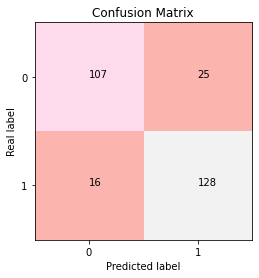

In [39]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
classes = [0, 1]
plt.ylabel('Real label')
plt.xlabel('Predicted label')
plt.xticks(classes)
plt.yticks(classes)
plt.title("Confusion Matrix")
for i in range(2):
    for j in range(2):
        plt.text(j,i, cm[i][j])
plt.show()

We can see that the model did not make many False Negatives (16 out of 276). It is not perfect, but it is good enough.

### Classification report:

In [40]:
report = classification_report(y_test, y_pred, output_dict = True)
pd.DataFrame(report).T

,precision,recall,f1-score,support
0,0.869919,0.810606,0.839216,132.000000
1,0.836601,0.888889,0.861953,144.000000
accuracy,0.851449,0.851449,0.851449,0.851449
macro avg,0.853260,0.849747,0.850584,276.000000
weighted avg,0.852536,0.851449,0.851079,276.000000


## Testing other models:

I have picked some classifiers to test, and use the one with the highest Recall.

In [41]:
KFold_Score = pd.DataFrame()
classifiers = ['Linear SVM', 'Poly SVM', 'Sigmoid SVM', 'Rbf SVM','LogisticRegression', 'RandomForestClassifier','GradientBoostingClassifier', 'AdaBoostClassifier']
models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='poly'),
          svm.SVC(kernel='sigmoid'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          GradientBoostingClassifier(random_state=0),
          AdaBoostClassifier(random_state=0)
         ]

In [42]:
j = 0
for i in models:
    model = i
    cv = KFold(n_splits=5, random_state=0, shuffle=True)
    KFold_Score[classifiers[j]] = (cross_val_score(model, X_train, y_train, scoring = 'recall', cv=cv))
    j = j+1

In [43]:
mean = pd.DataFrame(KFold_Score.mean(), index= classifiers)
KFold_Score = pd.concat([KFold_Score,mean.T])
KFold_Score.index=['Fold 1','Fold 2','Fold 3','Fold 4', 'Fold 5', 'Mean']
KFold_Score.T.sort_values(by=['Mean'], ascending = False)

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean
Poly SVM,0.920000,0.909091,0.914286,0.945946,0.955882,0.929041
Linear SVM,0.933333,0.870130,0.900000,0.851351,0.852941,0.881551
AdaBoostClassifier,0.826667,0.896104,0.914286,0.837838,0.926471,0.880273
LogisticRegression,0.906667,0.870130,0.900000,0.851351,0.852941,0.876218
RandomForestClassifier,0.866667,0.896104,0.900000,0.810811,0.897059,0.874128
Rbf SVM,0.920000,0.844156,0.885714,0.837838,0.882353,0.874012
GradientBoostingClassifier,0.866667,0.909091,0.900000,0.824324,0.867647,0.873546
Sigmoid SVM,0.813333,0.844156,0.785714,0.797297,0.764706,0.801041


After testing multiple models, we can see that Polynomial Svm outperformed them all. so we will tune further more and finally use it to predict our targer variable.

### Hyper-parameter tunning

In [44]:
params = {
    "C": [1, 10],
    "gamma": [0.001, 0.01, 1],
}
svm_grid = GridSearchCV(svm.SVC(kernel='poly'), params, cv=3, scoring='recall')
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(kernel='poly'),
             param_grid={'C': [1, 10], 'gamma': [0.001, 0.01, 1]},
             scoring='recall')

In [45]:
print("Best estimator:",svm_grid.best_estimator_)
print("Best score:", svm_grid.best_score_)

Best estimator: SVC(C=1, gamma=0.001, kernel='poly')
Best score: 1.0


### Fitting polynomial SVM model

In [46]:
model_svm = svm.SVC(kernel="poly", C=1, gamma=0.001)
model_svm.fit(X_train, y_train)

SVC(C=1, gamma=0.001, kernel='poly')

In [47]:
y_pred = model_svm.predict(X_test)

### Results

In [48]:
print("Recall score |", recall_score(y_test, y_pred))
print("Accuracy score |", accuracy_score(y_test, y_pred))
print("F1-score |", f1_score(y_test, y_pred))
print("Area under curve score | ", roc_auc_score(y_test, y_pred))

Recall score | 1.0
Accuracy score | 0.5217391304347826
F1-score | 0.6857142857142856
Area under curve score |  0.5


We can see that eventhough we have obtained a recall score of 1, AUC score is 0.5, which is the same as a model that has no class separation capacity whatsoever.

The choice of the model depends on the requirements set, do we need to avoid making mistakes sending away people that turn out to have sickness, or we want a model that is right most of the time? <br>
There maybe other classifiers that will do better that the ones stated above, also we can further tune the hyper parameters of KNN to obtain better results, or better, we can create other variables starting from the variables available, but that requires domain expertise. <br>

`Thank you for reading the notebook till the end, have a great day.`